### Wholesale Customer Segmentation

In this project, I'm trying to apply various clustering methods on the [Wholesale Customer dataset](https://archive.ics.uci.edu/dataset/292/wholesale+customers) downloaded from UCI Machine Learning Repository.

The dataset refers to clients of a wholesale distributor. It includes the annual spending in monetary units on 6 diverse product categories.

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### 1. Explortatry Data Analysis

The raw data is pretty clean with no missing data.

In [159]:
data = pd.read_csv(r"data/Wholesale customers data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


The dataset contains 2 categorical variables `Channel` and `Region`.

| Variable Name | Role | Type | Description | Units | Missing Values |
|---|---|---|---|---|---|
| Channel | Feature | Categorical | | | no |
| Region | Target | Categorical | | | no |
| Fresh | Feature | Integer | | | no |
| Milk | Feature | Integer | | | no |
| Grocery | Feature | Integer | | | no |
| Frozen | Feature | Integer | | | no |
| Detergents_Paper | Feature | Integer | | | no |
| Delicassen | Feature | Integer | | | no |

In [160]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Drop the 2 categorical variables for this exercise.

In [161]:
data.drop(['Channel', 'Region'], axis=1, inplace=True)
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


The distributions of all variables are right-skewed, with most observations clustered at lower values and extended tails. To prepare the data for modeling, feature rescaling and outlier treatment may be necessary.

Additionally, **Milk**, **Grocery**, and **Detergents_Paper** show notable correlations in spending patterns, with **Grocery** and **Detergents_Paper** exhibiting the strongest pairwise correlation of 0.92.

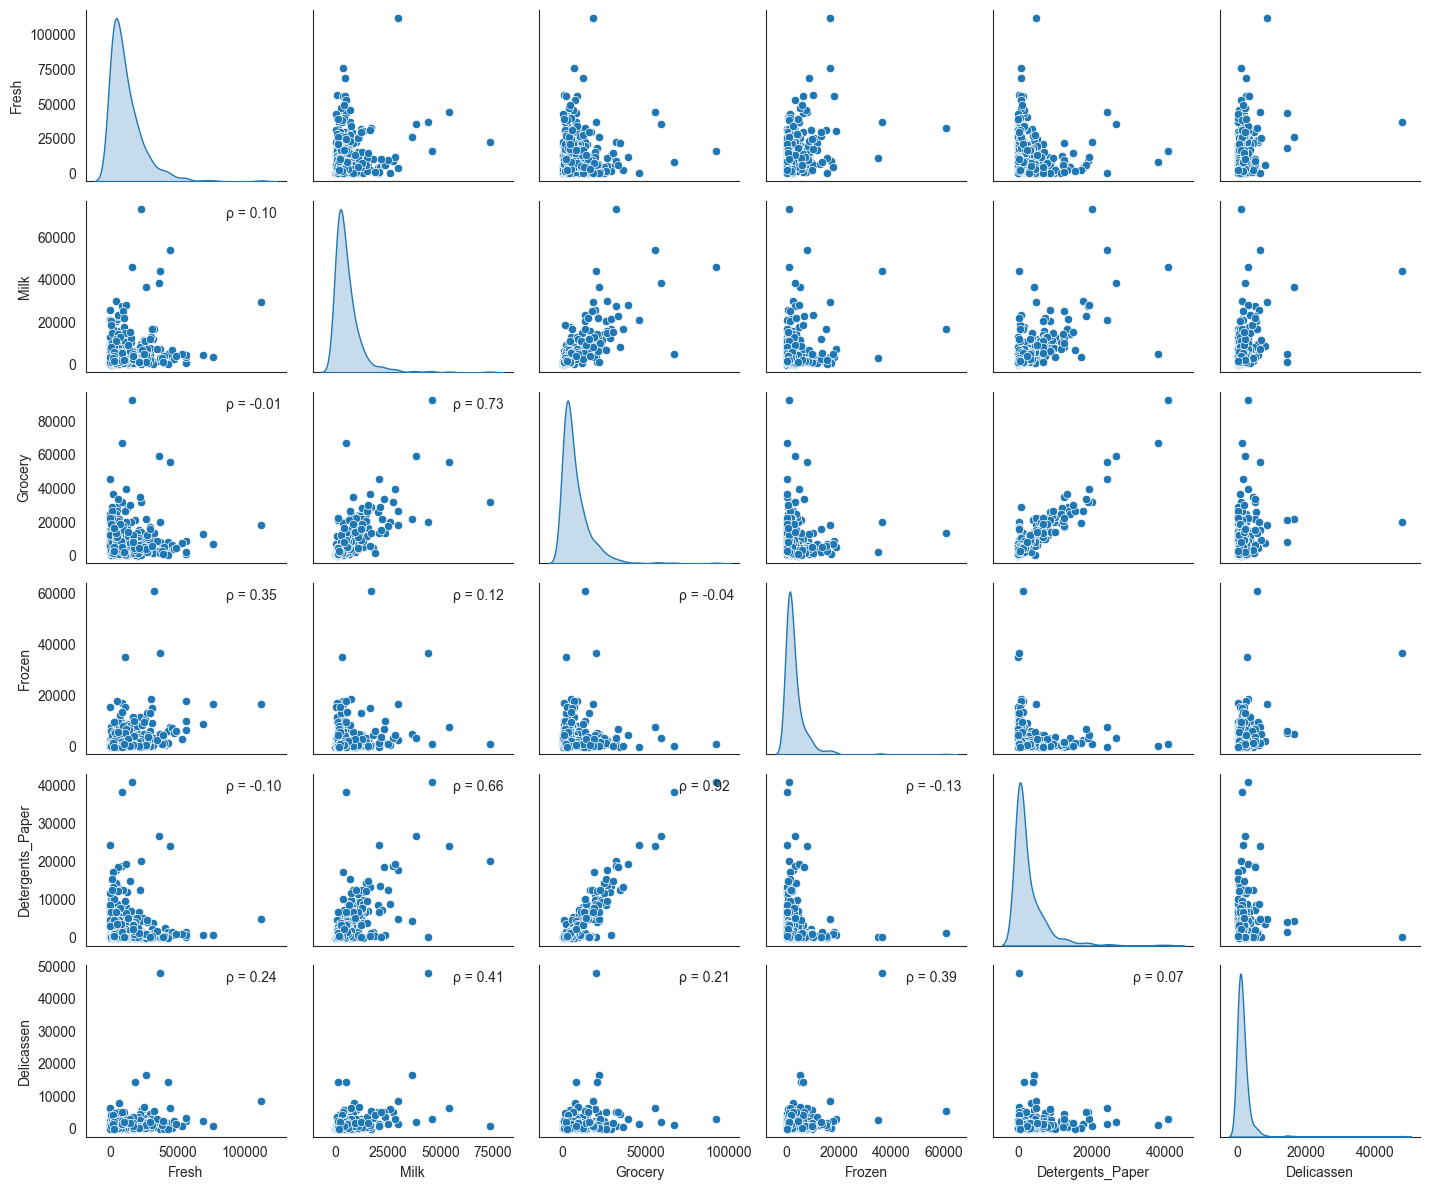

In [162]:
from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.7, .9), xycoords=ax.transAxes)

sns.set_style("white")
g = sns.pairplot(data, diag_kind='kde', height=2, aspect=1.2)
g.map_lower(corrfunc)
plt.tight_layout()
plt.show()

#### 2. Feature Pre-processing

As mentioned in the previous steps, the dataset is pretty skewed and with potential outliers, we need to preprocess the data to have a better representation of the features. This is usually a critical step before modeling to ensure the analysis is significant and robust.

After re-scaling the dataset using log transformation, the distributions of the features appear to be more normalized. And the correlations between features are broadly preserved.

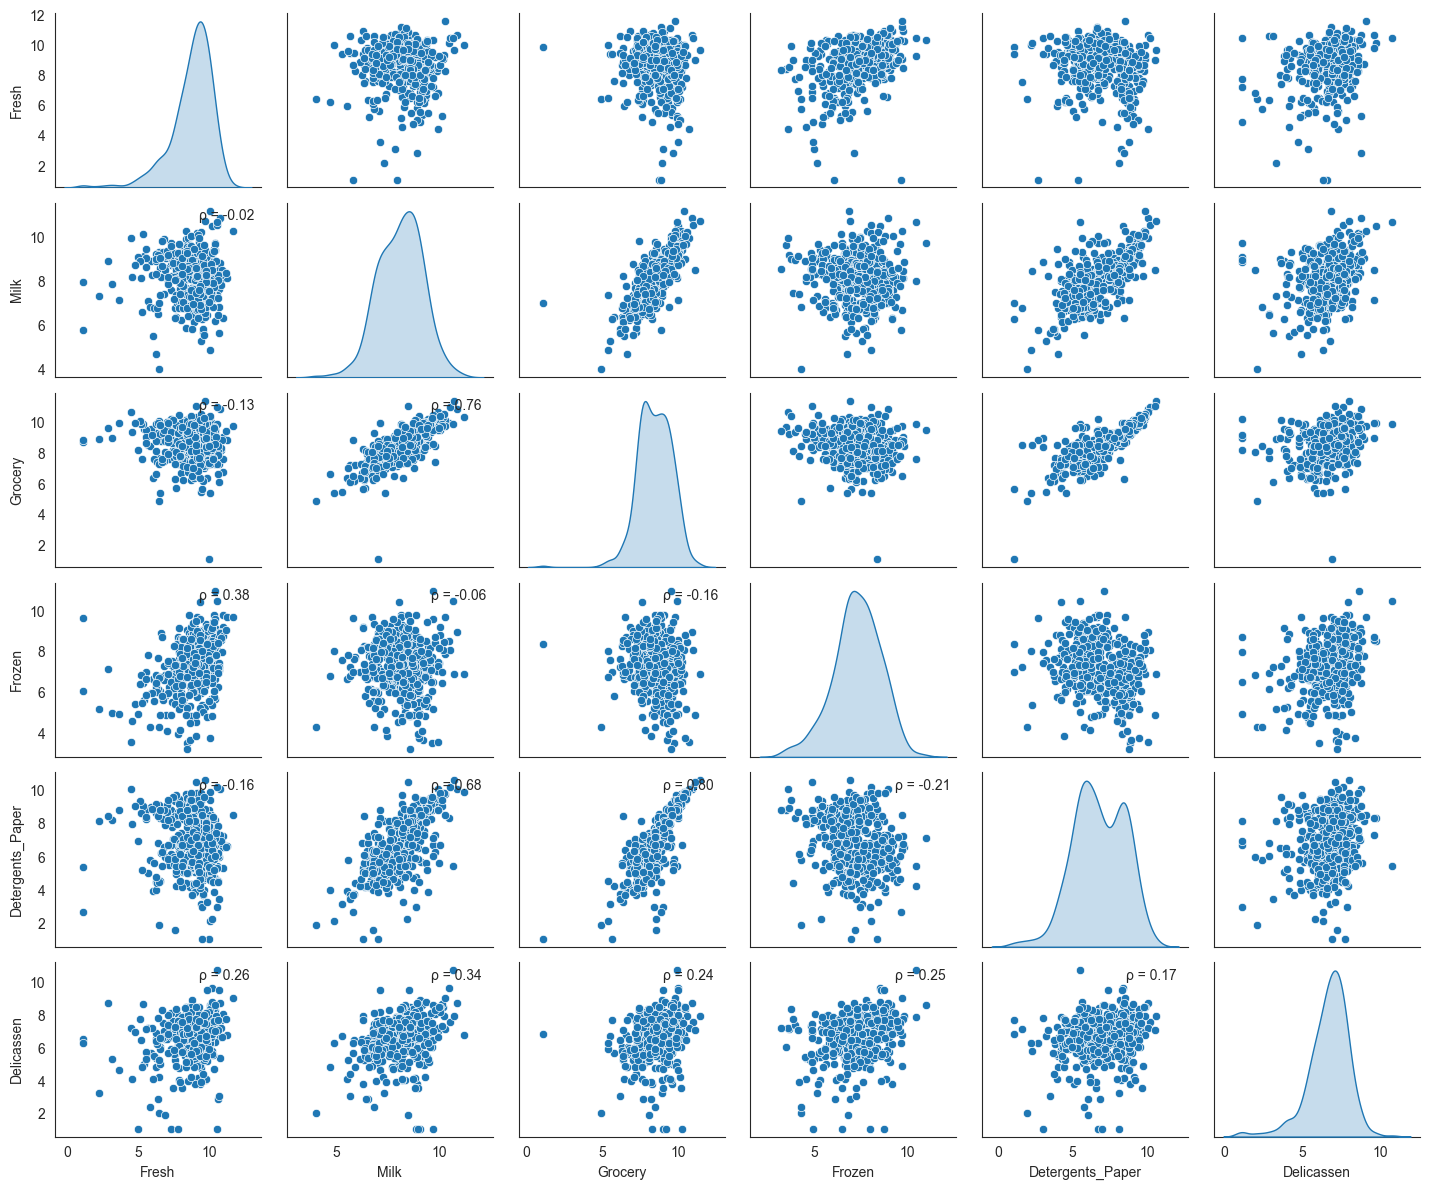

In [163]:
log_data = np.log(data.copy())

sns.set_style("white")
g = sns.pairplot(log_data, diag_kind='kde', height=2, aspect=1.2)
g.map_lower(corrfunc)
plt.tight_layout()
plt.show()

For outlier detection in multivariate settings, it's recommended to consider the dependency across variables. Mahalanobis distance is pretty suitable in this setting, which normalize the distance with the covariance matrix:

$$d^2 = (x - \mu)^T \Sigma^{-1} (x - \mu) $$

where:

$d$: Mahalanobis distance
$\Sigma^{-1}$: the inverse of the covariance matrix
$x$: vector of variables
$\mu$: center point of the vectors

After calculating the Mahalanobis distance, we use chi-square probability densitfy function as a threshold to identify the outliers.

In [164]:
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis

def mahalanobis_outlier(df):
    covariance = np.cov(df, rowvar=False)
    inv_cov_matrix = np.linalg.inv(covariance)
    center_point = np.mean(df, axis=0)

    # calculate mahalanobis distance
    distances = []
    for idx, row in df.iterrows():
        dist = mahalanobis(row.values, center_point, inv_cov_matrix)
        distances.append(dist)

    cutoff = chi2.ppf(0.5, df=df.shape[1])
    # print(f'cutoff = {cutoff}')
    # print(f'distances = {distances}')

    return np.where(distances > cutoff)


In [165]:
# from sklearn.ensemble import IsolationForest
#
# clf = IsolationForest(contamination=0.05, random_state=42)
# outlier_labels = clf.fit_predict(log_data)
# outlier_mask = (outlier_labels == -1)
# log_data.iloc[outlier_mask]

In [166]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_labels = lof.fit_predict(log_data)
outlier_mask = (outlier_labels == -1)
log_data.iloc[outlier_mask]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
47,10.702480,10.901524,10.925417,8.959569,10.092909,8.774158
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
71,9.814164,7.143618,9.954276,8.589142,8.336390,9.579971
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101
177,9.453992,8.899731,8.419139,7.468513,2.995732,7.875119
181,11.627601,10.296441,9.806316,9.725855,8.506739,9.053687


In [167]:
# outlier_mask = mahalanobis_outlier(log_data)
# log_data.iloc[outlier_mask]

In [168]:
# print(f"Data points considered outliers for the feature in index: '{list(outlier_mask)}'")
clean_data = log_data.drop(log_data.index[outlier_mask])

#### 3. Model Building

Next step, we applied a few unsupervised learning models, i.e., PCA, K-Means and DBSCAN to cluster the datasets into different segments.

Given that there is no ground truth in the dataset, we use Silhouette Score to evaluate the result of different models. The Silhouette Score is calculated using the mean intra-cluster distance ($a$) and the mean nearest cluster distance ($b$) for each sample:

$$ Silhouette\ Score = \frac{b - a}{max(a, b)}$$

In [169]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

As many clustering algorithms rely on distance-based metrics, we needt to standardize our features or else the feature with large scale will dominate the distance computation

In [170]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_data = scaler.fit_transform(clean_data)

In [171]:
best_kmeans_score = 0
best_kmeans_model = None
for i in range(2, 8):
    kmeans = KMeans(n_clusters=i, random_state=42)
    score = silhouette_score(x_data, kmeans.fit_predict(x_data))
    if score > best_kmeans_score:
        best_kmeans_score = score
        best_kmeans_model = kmeans

kmeans_labels = best_kmeans_model.labels_
print(best_kmeans_model)
print(f"The best silhouette score for K-means is {best_kmeans_score:.2f}")

KMeans(n_clusters=2, random_state=42)
The best silhouette score for K-means is 0.31


In [172]:
best_dbscan_score = 0
best_dbscan_model = None
for i in [0.3, 0.5]:
    dbscan = DBSCAN(eps=i, min_samples=1)
    score = silhouette_score(x_data, dbscan.fit_predict(x_data))
    if score > best_dbscan_score:
        best_dbscan_score = score
        best_dbscan_model = dbscan

dbscan_labels = best_dbscan_model.labels_
print(best_dbscan_model)
print(f"The best silhouette score for DBSCAN is {best_dbscan_score:.2f}")

DBSCAN(min_samples=1)
The best silhouette score for DBSCAN is 0.04


In [173]:
best_agglomer_score = 0
best_agglomer_model = None
for i in range(3, 10):
    for linkage in ['ward', 'average']:
        agglomer = AgglomerativeClustering(linkage=linkage, n_clusters=i)
        score = silhouette_score(x_data, agglomer.fit_predict(x_data))
        if score > best_agglomer_score:
            best_agglomer_score = score
            best_agglomer_model = agglomer
            agglomer_labels = best_agglomer_model.labels_

print(best_agglomer_model)
print(f"The best silhouette score for Agglomerative clustering is {best_agglomer_score:.2f}")

AgglomerativeClustering(linkage='average', n_clusters=3)
The best silhouette score for Agglomerative clustering is 0.30


In [174]:
best_gmm_score = 0
best_gmm_model = None
for i in range(2, 10):
    gmm = GaussianMixture(n_components=i, random_state=42).fit(x_data)
    score = silhouette_score(x_data, gmm.predict(x_data))
    if score > best_gmm_score:
        best_gmm_score = score
        best_gmm_model = gmm
        gmm_labels = gmm.predict(x_data)

print(best_gmm_model)
print(f"The best silhouette score for Gaussian Mixture Model is {best_gmm_score:.2f}")

GaussianMixture(n_components=2, random_state=42)
The best silhouette score for Gaussian Mixture Model is 0.29


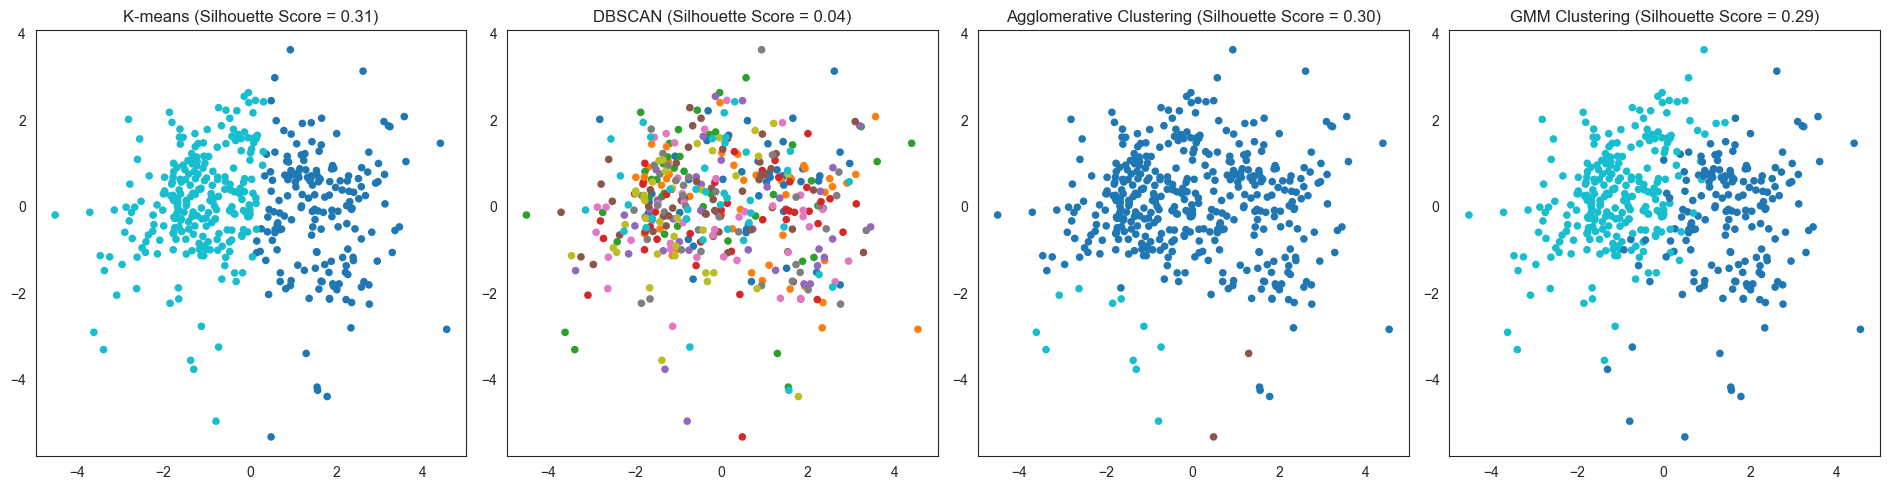

In [176]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_data
                          )

fig, axs = plt.subplots(1, 4, figsize=(19, 5))

axs[0].scatter(x_pca[:, 0], x_pca[:, 1], c=kmeans_labels, cmap='tab10', s=20)
axs[0].set_title(f'K-means (Silhouette Score = {best_kmeans_score:.2f})')
axs[0].grid(False)

axs[1].scatter(x_pca[:, 0], x_pca[:, 1], c=dbscan_labels, cmap='tab10', s=20)
axs[1].set_title(f'DBSCAN (Silhouette Score = {best_dbscan_score:.2f})')
axs[1].grid(False)

axs[2].scatter(x_pca[:, 0], x_pca[:, 1], c=agglomer_labels, cmap='tab10', s=20)
axs[2].set_title(f'Agglomerative Clustering (Silhouette Score = {best_agglomer_score:.2f})')
axs[2].grid(False)

axs[3].scatter(x_pca[:, 0], x_pca[:, 1], c=gmm_labels, cmap='tab10', s=20)
axs[3].set_title(f'GMM Clustering (Silhouette Score = {best_gmm_score:.2f})')
axs[3].grid(False)

plt.tight_layout()
plt.show()

#### 4. Conclusion